# Flowers102 Image Classification Training
This notebook trains a ResNet18 model on the Flowers102 dataset with early stopping and TensorBoard logging.

## Training Instructions
To train the model on local machine, you also can run the script from terminal. 

**Command:**
```bash
python src/training/train.py --epochs 25 --batch_size 32 --lr 0.001 --patience 7
```

**Key Arguments:**
- `--epochs`: Maximum number of training epochs (default: 25)
- `--patience`: Early stopping patience (default: 7)
- `--lr`: Learning rate (default: 0.001)
- `--batch_size`: Batch size (default: 32)

## 1. Imports and Setup

In [105]:
import os
import sys

# Set up paths
project_root = os.path.abspath('../src')
if project_root not in sys.path:
    sys.path.append(project_root)

In [106]:
import torch
import torch.nn as torch_nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torch.utils.tensorboard import SummaryWriter
from torchvision import models
from torchvision.datasets import Flowers102
import time
import copy
import numpy as np
import logging
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix
import datetime
from data.loader import Flowers102Dataset, get_transforms
from utils.common import set_seed, save_checkpoint

## 2. Early Stopping Class

In [108]:
class EarlyStopping:
    """Early stops the training if validation loss doesn't improve after a given patience."""
    def __init__(self, patience=7, verbose=False, delta=0, path='checkpoint.pt', trace_func=print):
        self.patience = patience
        self.verbose = verbose
        self.counter = 0
        self.best_score = None
        self.early_stop = False
        self.val_loss_min = np.inf
        self.delta = delta
        self.path = path
        self.trace_func = trace_func

    def __call__(self, val_loss, model):
        score = -val_loss
        if self.best_score is None:
            self.best_score = score
            self.save_checkpoint(val_loss, model)
        elif score < self.best_score + self.delta:
            self.counter += 1
            if self.verbose:
                self.trace_func(f'EarlyStopping counter: {self.counter} out of {self.patience}')
            if self.counter >= self.patience:
                self.early_stop = True
        else:
            self.best_score = score
            self.save_checkpoint(val_loss, model)
            self.counter = 0

    def save_checkpoint(self, val_loss, model):
        '''Saves model when validation loss decrease.'''
        if self.verbose:
            self.trace_func(f'Validation loss decreased ({self.val_loss_min:.6f} --> {val_loss:.6f}).  Saving model ...')
        os.makedirs(os.path.dirname(self.path), exist_ok=True)
        torch.save(model.state_dict(), self.path)
        self.val_loss_min = val_loss

## 3. Training Function

In [109]:
def train_model(model, dataloaders, criterion, optimizer, num_epochs=25, device='cuda', logger=None, writer=None, patience=7):
    since = time.time()
    history = {'train_acc': [], 'val_acc': [], 'train_loss': [], 'val_loss': []}
    
    os.makedirs('../src/model', exist_ok=True)
    early_stopping = EarlyStopping(patience=patience, verbose=True, path='../src/model/early_stop.pth')

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    for epoch in range(num_epochs):
        if logger:
            logger.info(f'Epoch {epoch}/{num_epochs - 1}')
            logger.info('-' * 10)

        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()
            else:
                model.eval()

            running_loss = 0.0
            running_corrects = 0

            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)

                optimizer.zero_grad()

                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    loss = criterion(outputs, labels)
                    _, preds = torch.max(outputs, 1)

                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)

            epoch_loss = running_loss / len(dataloaders[phase].dataset)
            epoch_acc = running_corrects.double() / len(dataloaders[phase].dataset)

            if phase == 'train':
                history['train_acc'].append(epoch_acc.cpu().numpy())
                history['train_loss'].append(epoch_loss)
            else:  
                history['val_acc'].append(epoch_acc.cpu().numpy())
                history['val_loss'].append(epoch_loss)

            if logger:
                logger.info(f'{phase} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}')
            
            if writer:
                writer.add_scalar(f'Loss/{phase}', epoch_loss, epoch)
                writer.add_scalar(f'Accuracy/{phase}', epoch_acc, epoch)

            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())
            
            if phase == 'val':
                early_stopping(epoch_loss, model)
                if early_stopping.early_stop:
                    if logger:
                        logger.info("Early stopping")
                    model.load_state_dict(best_model_wts) 
                    return model, history

        if logger:
            logger.info('')

    time_elapsed = time.time() - since
    if logger:
        logger.info(f'Training complete in {time_elapsed // 60:.0f}m {time_elapsed % 60:.0f}s')
        logger.info(f'Best val Acc: {best_acc:4f}')

    model.load_state_dict(best_model_wts)
    return model, history

## 4.. Evaluation Metrics Function

In [111]:
def evaluate_metrics(model, dataloaders, device, writer, num_classes=102):
    """
    Compute and log Confusion Matrix and Class-wise Accuracy.
    """
    model.eval()
    y_true = []
    y_pred = []
    
    print("Collecting predictions...")
    # Collect all predictions
    with torch.no_grad():
        for inputs, labels in dataloaders['val']:
            inputs = inputs.to(device)
            labels = labels.to(device)
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            y_true.extend(labels.cpu().numpy())
            y_pred.extend(preds.cpu().numpy())
    
    print(f"Total predictions collected: {len(y_true)}")
    
    # 1. Confusion Matrix
    cm = confusion_matrix(y_true, y_pred, labels=list(range(num_classes)))
    
    # Plotting
    print("Generating confusion matrix plot...")
    plt.figure(figsize=(20, 20))
    sns.heatmap(cm, annot=False, fmt='d', cmap='Blues')
    plt.title('Confusion Matrix')
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    plt.tight_layout()
    
    plt.show()
    
    if writer:
        # Create a new figure for TensorBoard since we already showed the previous one
        plt.figure(figsize=(20, 20))
        sns.heatmap(cm, annot=False, fmt='d', cmap='Blues')
        plt.title('Confusion Matrix')
        plt.ylabel('True Label')
        plt.xlabel('Predicted Label')
        plt.tight_layout()
        writer.add_figure('Confusion Matrix', plt.gcf())
        plt.close()
        
        # 2. Add Class-wise Accuracy to text/scalars
        # Calculate per-class accuracy, handling division by zero
        class_totals = cm.sum(axis=1)
        class_accuracy = np.divide(
            cm.diagonal(), 
            class_totals, 
            out=np.zeros_like(cm.diagonal(), dtype=float),
            where=class_totals != 0
        )
        
        # Count how many classes were actually present in validation set
        classes_present = np.sum(class_totals > 0)
        print(f"Classes present in validation set: {classes_present}/{num_classes}")
        print(f"Mean accuracy (for present classes): {class_accuracy[class_totals > 0].mean():.4f}")
        
        for i, acc in enumerate(class_accuracy):
            if class_totals[i] > 0:  # Only log classes that were present
                writer.add_scalar(f'Accuracy/Class_{i}', acc, 0)
    
    print("Confusion matrix evaluation complete!")

## 5. Configuration

In [112]:
class Args:
    data_dir = '../src/data'
    batch_size = 32
    epochs = 20
    lr = 0.001
    seed = 42
    patience = 5
    dry_run = False  # Change to False for full training

args = Args()
set_seed(args.seed)

logger.info(f"Starting training with args: {args.__dict__}")

# Device setup
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
logger.info(f"Using device: {device}")

2025-12-31 15:01:36,715 - INFO - Starting training with args: {}
2025-12-31 15:01:36,719 - INFO - Using device: cuda:0


## 6. TensorBoard Setup

In [113]:
timestamp = datetime.datetime.now().strftime('%d%m%Y-%H%M%S')
log_dir_tb = os.path.join('../logs/tensorboard/notebook_run', f'run{timestamp}', 'train')
writer = SummaryWriter(log_dir_tb)
logger.info(f"TensorBoard logs will be saved to: {log_dir_tb}")

2025-12-31 15:01:36,743 - INFO - TensorBoard logs will be saved to: ../logs/tensorboard/notebook_run\run31122025-150136\train


## 7. Load Datasets (Original Dataset Split)

In [114]:
image_datasets = {
    x: Flowers102(root=args.data_dir, split=x, transform=get_transforms(x), download=True)
    for x in ['train', 'val']
}

if args.dry_run:
    logger.info("Dry run enabled: Using subset of data (10 samples)")
    image_datasets = {x: torch.utils.data.Subset(image_datasets[x], range(10)) for x in ['train', 'val']}

dataloaders = {
    x: DataLoader(image_datasets[x], batch_size=args.batch_size, shuffle=(x == 'train'), num_workers=0)
    for x in ['train', 'val']
}

dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'val']}
logger.info(f"Dataset sizes: {dataset_sizes}")

2025-12-31 15:01:36,787 - INFO - Dataset sizes: {'train': 1020, 'val': 1020}


## 8. Initialize Model

In [115]:
model_ft = models.resnet18(weights=models.ResNet18_Weights.IMAGENET1K_V1)
num_ftrs = model_ft.fc.in_features
model_ft.fc = torch_nn.Linear(num_ftrs, 102)
model_ft = model_ft.to(device)

logger.info(f"Model initialized with {num_ftrs} input features to final layer")

2025-12-31 15:01:36,981 - INFO - Model initialized with 512 input features to final layer


In [116]:
print(model_ft)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

## 9. Define Loss and Optimizer

In [118]:
criterion = torch_nn.CrossEntropyLoss()
optimizer_ft = optim.SGD(model_ft.parameters(), lr=args.lr, momentum=0.9)

logger.info(f"Using CrossEntropyLoss and SGD optimizer with lr={args.lr}")

2025-12-31 15:01:37,717 - INFO - Using CrossEntropyLoss and SGD optimizer with lr=0.001


## 10. Train the Model with Original Dataset Split

In [119]:
num_epochs = 1 if args.dry_run else args.epochs
model_ft, hist = train_model(
    model_ft, 
    dataloaders, 
    criterion, 
    optimizer_ft, 
    num_epochs=num_epochs, 
    device=device, 
    logger=logger, 
    writer=writer, 
    patience=args.patience
)

2025-12-31 15:01:37,742 - INFO - Epoch 0/19
2025-12-31 15:01:37,742 - INFO - ----------
2025-12-31 15:01:52,093 - INFO - train Loss: 4.6876 Acc: 0.0167
2025-12-31 15:02:01,167 - INFO - val Loss: 4.3597 Acc: 0.0755
Validation loss decreased (inf --> 4.359662).  Saving model ...
2025-12-31 15:02:01,278 - INFO - 
2025-12-31 15:02:01,279 - INFO - Epoch 1/19
2025-12-31 15:02:01,280 - INFO - ----------
2025-12-31 15:02:12,237 - INFO - train Loss: 4.0278 Acc: 0.1951
2025-12-31 15:02:19,535 - INFO - val Loss: 3.8207 Acc: 0.3147
Validation loss decreased (4.359662 --> 3.820672).  Saving model ...
2025-12-31 15:02:19,620 - INFO - 
2025-12-31 15:02:19,620 - INFO - Epoch 2/19
2025-12-31 15:02:19,620 - INFO - ----------
2025-12-31 15:02:30,518 - INFO - train Loss: 3.4023 Acc: 0.5108
2025-12-31 15:02:37,516 - INFO - val Loss: 3.2701 Acc: 0.5078
Validation loss decreased (3.820672 --> 3.270105).  Saving model ...
2025-12-31 15:02:37,623 - INFO - 
2025-12-31 15:02:37,624 - INFO - Epoch 3/19
2025-12-31

## 11. Save Checkpoint

In [120]:
os.makedirs('../src/model', exist_ok=True)
save_checkpoint({
    'epoch': num_epochs,
    'state_dict': model_ft.state_dict(),
    'best_acc': max(hist) if hist else 0.0,
    'optimizer': optimizer_ft.state_dict(),
}, is_best=True, filename='checkpoint_notebook.pth.tar', checkpoint_dir='../src/model')

logger.info("Model checkpoint saved successfully")

2025-12-31 15:08:17,500 - INFO - Model checkpoint saved successfully


## 12. Plot Training History


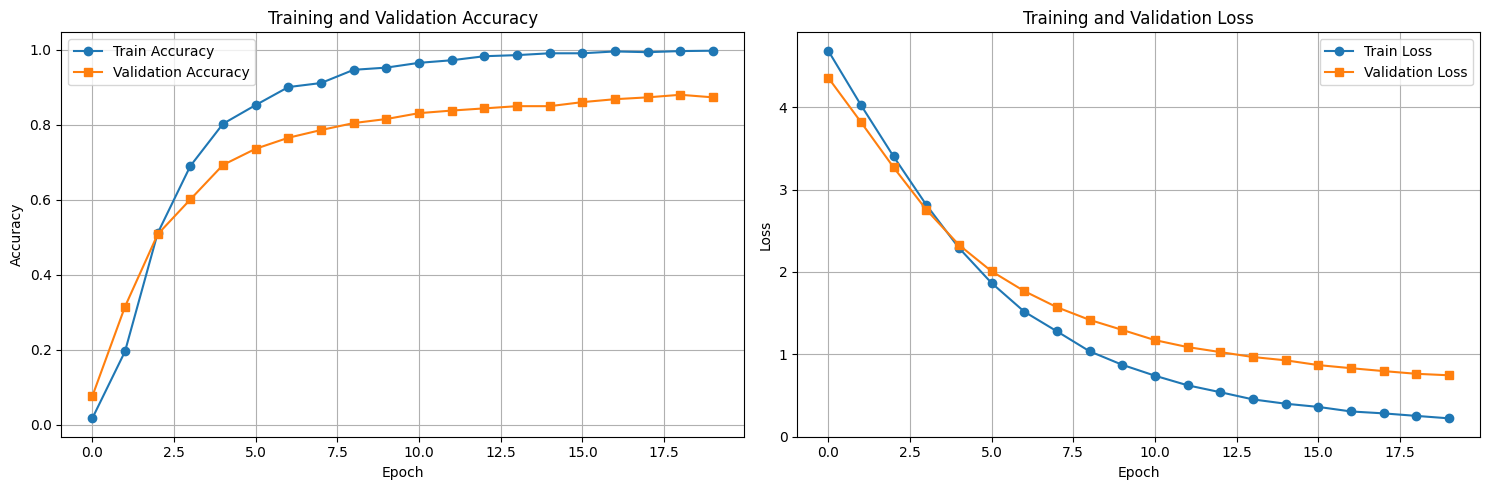

2025-12-31 15:08:17,865 - INFO - Best validation accuracy: 0.8804
2025-12-31 15:08:17,866 - INFO - Best validation loss: 0.7439


In [121]:
# Plot training history - accuracy and loss
if hist:
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))
    
    # Plot Accuracy
    epochs_range = range(len(hist['train_acc']))
    ax1.plot(epochs_range, hist['train_acc'], marker='o', label='Train Accuracy')
    ax1.plot(epochs_range, hist['val_acc'], marker='s', label='Validation Accuracy')
    ax1.set_title('Training and Validation Accuracy')
    ax1.set_xlabel('Epoch')
    ax1.set_ylabel('Accuracy')
    ax1.legend()
    ax1.grid(True)
    
    # Plot Loss
    ax2.plot(epochs_range, hist['train_loss'], marker='o', label='Train Loss')
    ax2.plot(epochs_range, hist['val_loss'], marker='s', label='Validation Loss')
    ax2.set_title('Training and Validation Loss')
    ax2.set_xlabel('Epoch')
    ax2.set_ylabel('Loss')
    ax2.legend()
    ax2.grid(True)
    
    plt.tight_layout()
    plt.show()
    
    logger.info(f"Best validation accuracy: {max(hist['val_acc']):.4f}")
    logger.info(f"Best validation loss: {min(hist['val_loss']):.4f}")
else:
    logger.info("No training history available")

This training plot is train using original dataset split. This is to compare the performance of the model with the original dataset split. The plot seems to be memorize training data as the graph looks overfitting.

## 13. Final Evaluation and Confusion Matrix

2025-12-31 15:08:17,876 - INFO - Running final evaluation (Confusion Matrix)...
Total predictions collected: 1020
Generating confusion matrix plot...


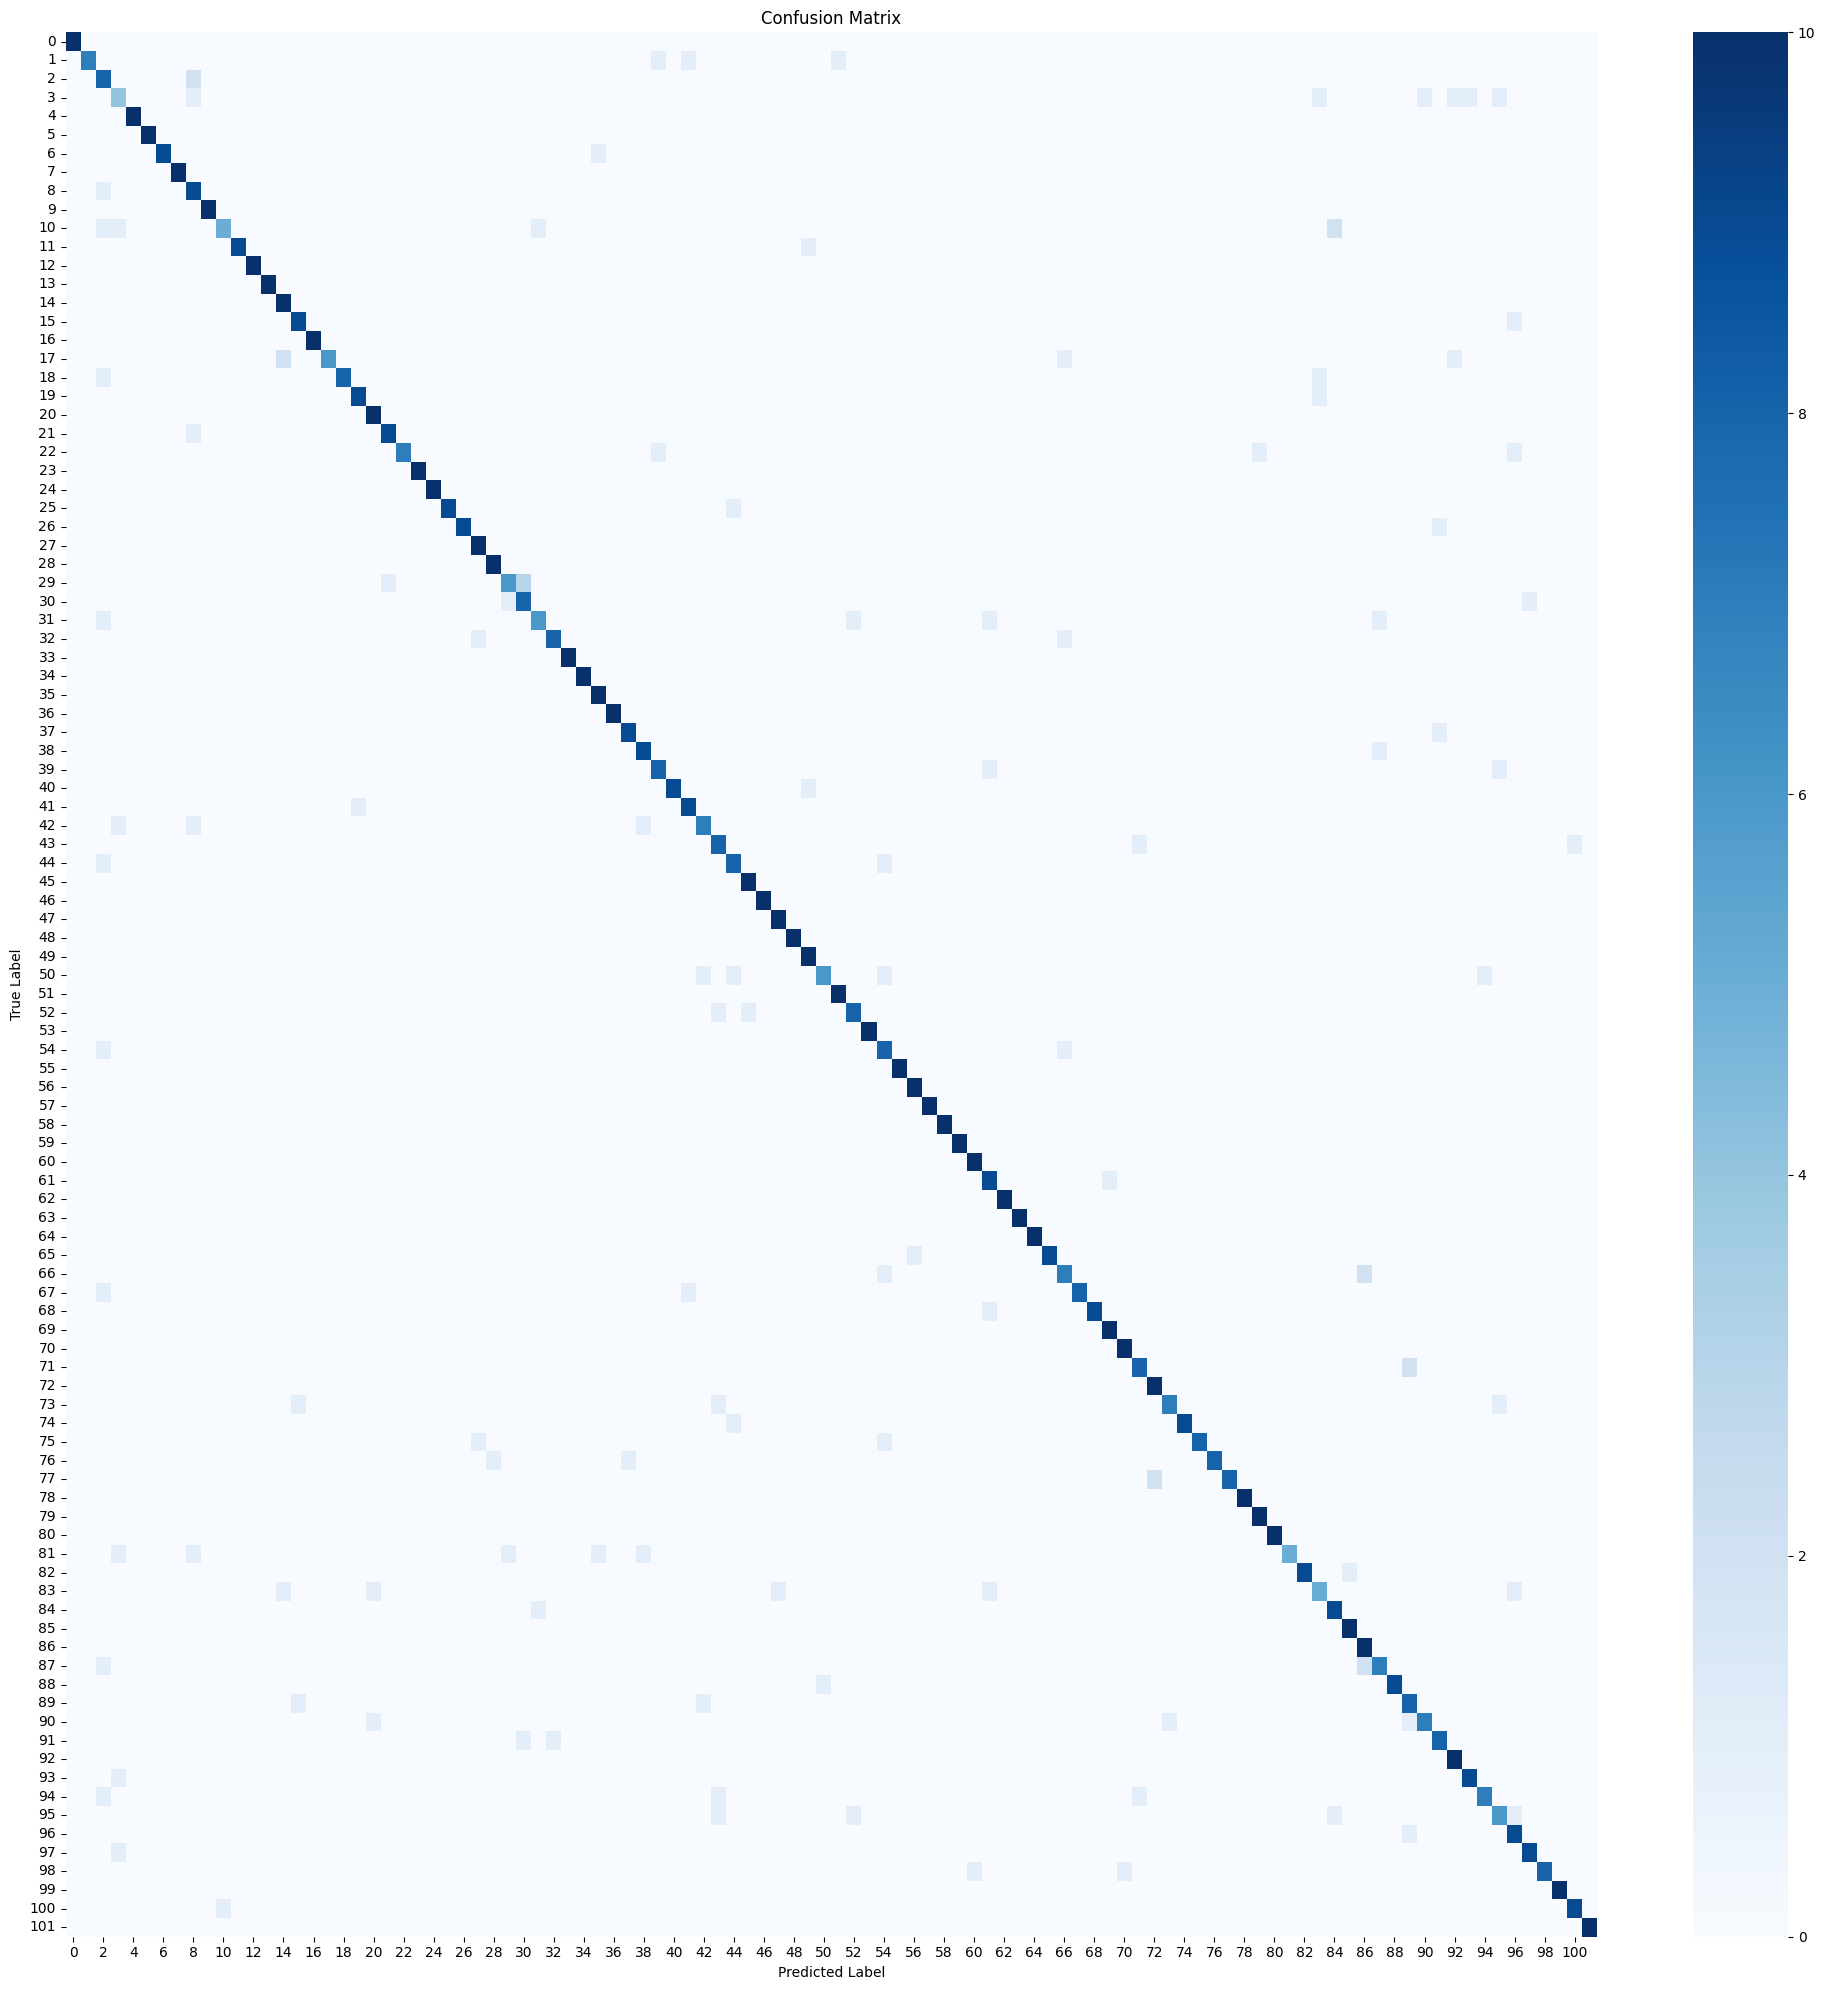

Classes present in validation set: 102/102
Mean accuracy (for present classes): 0.8804
Confusion matrix evaluation complete!


In [122]:
logger.info("Running final evaluation (Confusion Matrix)...")
evaluate_metrics(model_ft, dataloaders, device, writer, num_classes=102)

## 14. Load data from custom stratified dataset

In [124]:
image_datasets = {
    x: Flowers102Dataset(root=args.data_dir, split=x, transform=get_transforms(x), download=True)
    for x in ['train', 'val']
}

if args.dry_run:
    logger.info("Dry run enabled: Using subset of data (10 samples)")
    image_datasets = {x: torch.utils.data.Subset(image_datasets[x], range(10)) for x in ['train', 'val']}

dataloaders = {
    x: DataLoader(image_datasets[x], batch_size=args.batch_size, shuffle=(x == 'train'), num_workers=0)
    for x in ['train', 'val']
}

dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'val']}
logger.info(f"Dataset sizes: {dataset_sizes}")

2025-12-31 15:08:27,736 - INFO - Dataset sizes: {'train': 5732, 'val': 1228}


## 15. Calculate class weights

To tackle the imbalanced examples classes, we calculate class weights based on the inverse frequency of each class in the training dataset. 

In [ ]:
from sklearn.utils.class_weight import compute_class_weight

train_dataset = image_datasets['train']
train_labels = [train_dataset.labels[i] for i in train_dataset.indices]

# Compute Class Weights
class_weights = compute_class_weight(
    class_weight='balanced',
    classes=np.unique(train_labels),
    y=train_labels
)

# Convert to Tensor & Move to GPU
class_weights_tensor = torch.tensor(class_weights, dtype=torch.float)
class_weights_tensor = class_weights_tensor.to(device)

print(f"Class Weights Calculated.")
print(f"Min Weight: {class_weights_tensor.min():.2f} (Common Class)")
print(f"Max Weight: {class_weights_tensor.max():.2f} (Rare Class)")

Class Weights Calculated.
Min Weight: 0.31 (Common Class)
Max Weight: 2.01 (Rare Class)


## 16. Load model but freeze all layers except last fc layer

In [126]:
# 1. Load the pre-trained model
model_ft = models.resnet18(weights=models.ResNet18_Weights.IMAGENET1K_V1)
for param in model_ft.parameters():
    param.requires_grad = False

num_ftrs = model_ft.fc.in_features
model_ft.fc = torch_nn.Linear(num_ftrs, 102)
model_ft = model_ft.to(device)

logger.info(f"Model initialized with {num_ftrs} input features.")
logger.info("Backbone frozen. Only the final classification layer will be trained.")

2025-12-31 15:08:27,971 - INFO - Model initialized with 512 input features.
2025-12-31 15:08:27,972 - INFO - Backbone frozen. Only the final classification layer will be trained.


In [ ]:
total_params = sum(p.numel() for p in model_ft.parameters())
trainable_params = sum(p.numel() for p in model_ft.parameters() if p.requires_grad)

print(f"\nModel Summary:")
print(f"Total Parameters: {total_params:,}")
print(f"Trainable Parameters: {trainable_params:,}") 


Model Summary:
Total Parameters: 11,228,838
Trainable Parameters: 52,326


## 17. Define Loss and Optimizer

In [129]:
criterion = torch_nn.CrossEntropyLoss(weight=class_weights_tensor)
optimizer_ft = optim.SGD(model_ft.parameters(), lr=args.lr, momentum=0.9)

logger.info(f"Using CrossEntropyLoss and SGD optimizer with lr={args.lr}")

2025-12-31 15:08:29,124 - INFO - Using CrossEntropyLoss and SGD optimizer with lr=0.001


## 18. Initialize Training

In [130]:
num_epochs = 1 if args.dry_run else args.epochs
model_ft, hist = train_model(
    model_ft, 
    dataloaders, 
    criterion, 
    optimizer_ft, 
    num_epochs=num_epochs, 
    device=device, 
    logger=logger, 
    writer=writer, 
    patience=args.patience
)

2025-12-31 15:08:29,156 - INFO - Epoch 0/19
2025-12-31 15:08:29,157 - INFO - ----------
2025-12-31 15:09:12,214 - INFO - train Loss: 4.2178 Acc: 0.1265
2025-12-31 15:09:20,815 - INFO - val Loss: 3.5415 Acc: 0.3583
Validation loss decreased (inf --> 3.541544).  Saving model ...
2025-12-31 15:09:20,895 - INFO - 
2025-12-31 15:09:20,896 - INFO - Epoch 1/19
2025-12-31 15:09:20,897 - INFO - ----------
2025-12-31 15:10:01,889 - INFO - train Loss: 3.1316 Acc: 0.4963
2025-12-31 15:10:10,370 - INFO - val Loss: 2.6126 Acc: 0.6344
Validation loss decreased (3.541544 --> 2.612560).  Saving model ...
2025-12-31 15:10:10,433 - INFO - 
2025-12-31 15:10:10,434 - INFO - Epoch 2/19
2025-12-31 15:10:10,435 - INFO - ----------
2025-12-31 15:10:51,936 - INFO - train Loss: 2.3380 Acc: 0.7041
2025-12-31 15:11:00,668 - INFO - val Loss: 1.9939 Acc: 0.7549
Validation loss decreased (2.612560 --> 1.993927).  Saving model ...
2025-12-31 15:11:00,754 - INFO - 
2025-12-31 15:11:00,755 - INFO - Epoch 3/19
2025-12-31

## 19. Save checkpoint

In [131]:
os.makedirs('../src/model', exist_ok=True)
save_checkpoint({
    'epoch': num_epochs,
    'state_dict': model_ft.state_dict(),
    'best_acc': max(hist) if hist else 0.0,
    'optimizer': optimizer_ft.state_dict(),
}, is_best=True, filename='checkpoint_notebook.pth.tar', checkpoint_dir='../src/model')

logger.info("Model checkpoint saved successfully")

2025-12-31 15:25:24,064 - INFO - Model checkpoint saved successfully


## 20. Plot Training and Validation Loss

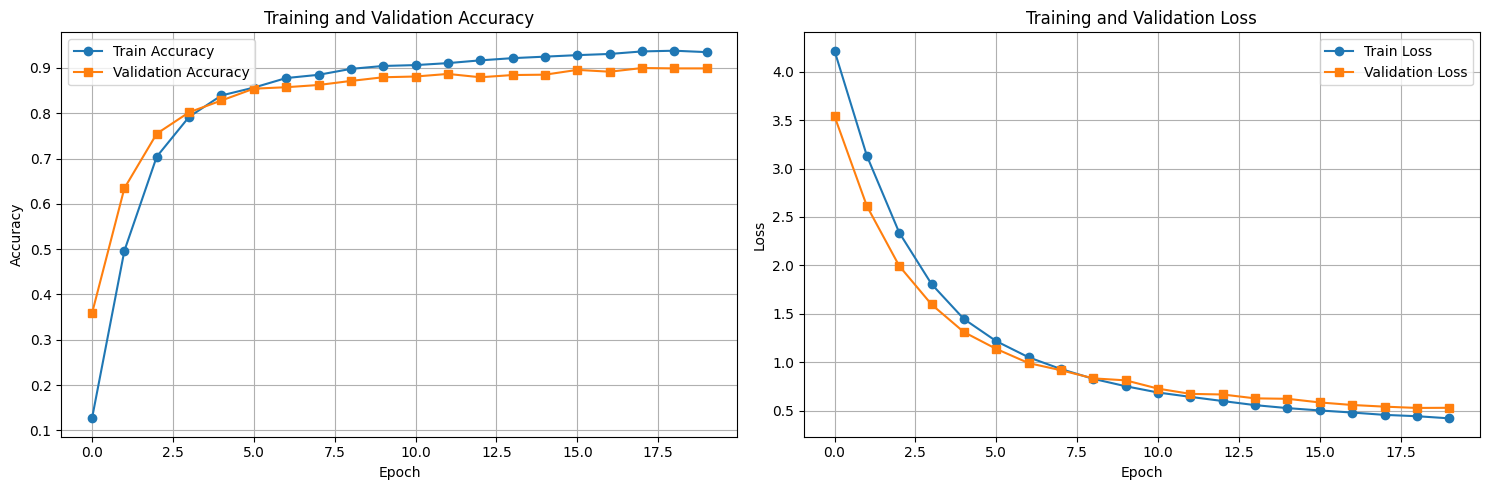

2025-12-31 15:25:24,356 - INFO - Best validation accuracy: 0.8998
2025-12-31 15:25:24,356 - INFO - Best validation loss: 0.5266


In [132]:
# Plot training history - accuracy and loss
if hist:
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))
    
    # Plot Accuracy
    epochs_range = range(len(hist['train_acc']))
    ax1.plot(epochs_range, hist['train_acc'], marker='o', label='Train Accuracy')
    ax1.plot(epochs_range, hist['val_acc'], marker='s', label='Validation Accuracy')
    ax1.set_title('Training and Validation Accuracy')
    ax1.set_xlabel('Epoch')
    ax1.set_ylabel('Accuracy')
    ax1.legend()
    ax1.grid(True)
    
    # Plot Loss
    ax2.plot(epochs_range, hist['train_loss'], marker='o', label='Train Loss')
    ax2.plot(epochs_range, hist['val_loss'], marker='s', label='Validation Loss')
    ax2.set_title('Training and Validation Loss')
    ax2.set_xlabel('Epoch')
    ax2.set_ylabel('Loss')
    ax2.legend()
    ax2.grid(True)
    
    plt.tight_layout()
    plt.show()
    
    logger.info(f"Best validation accuracy: {max(hist['val_acc']):.4f}")
    logger.info(f"Best validation loss: {min(hist['val_loss']):.4f}")
else:
    logger.info("No training history available")

2025-12-31 15:25:24,365 - INFO - Running final evaluation (Confusion Matrix)...
Total predictions collected: 1228
Generating confusion matrix plot...


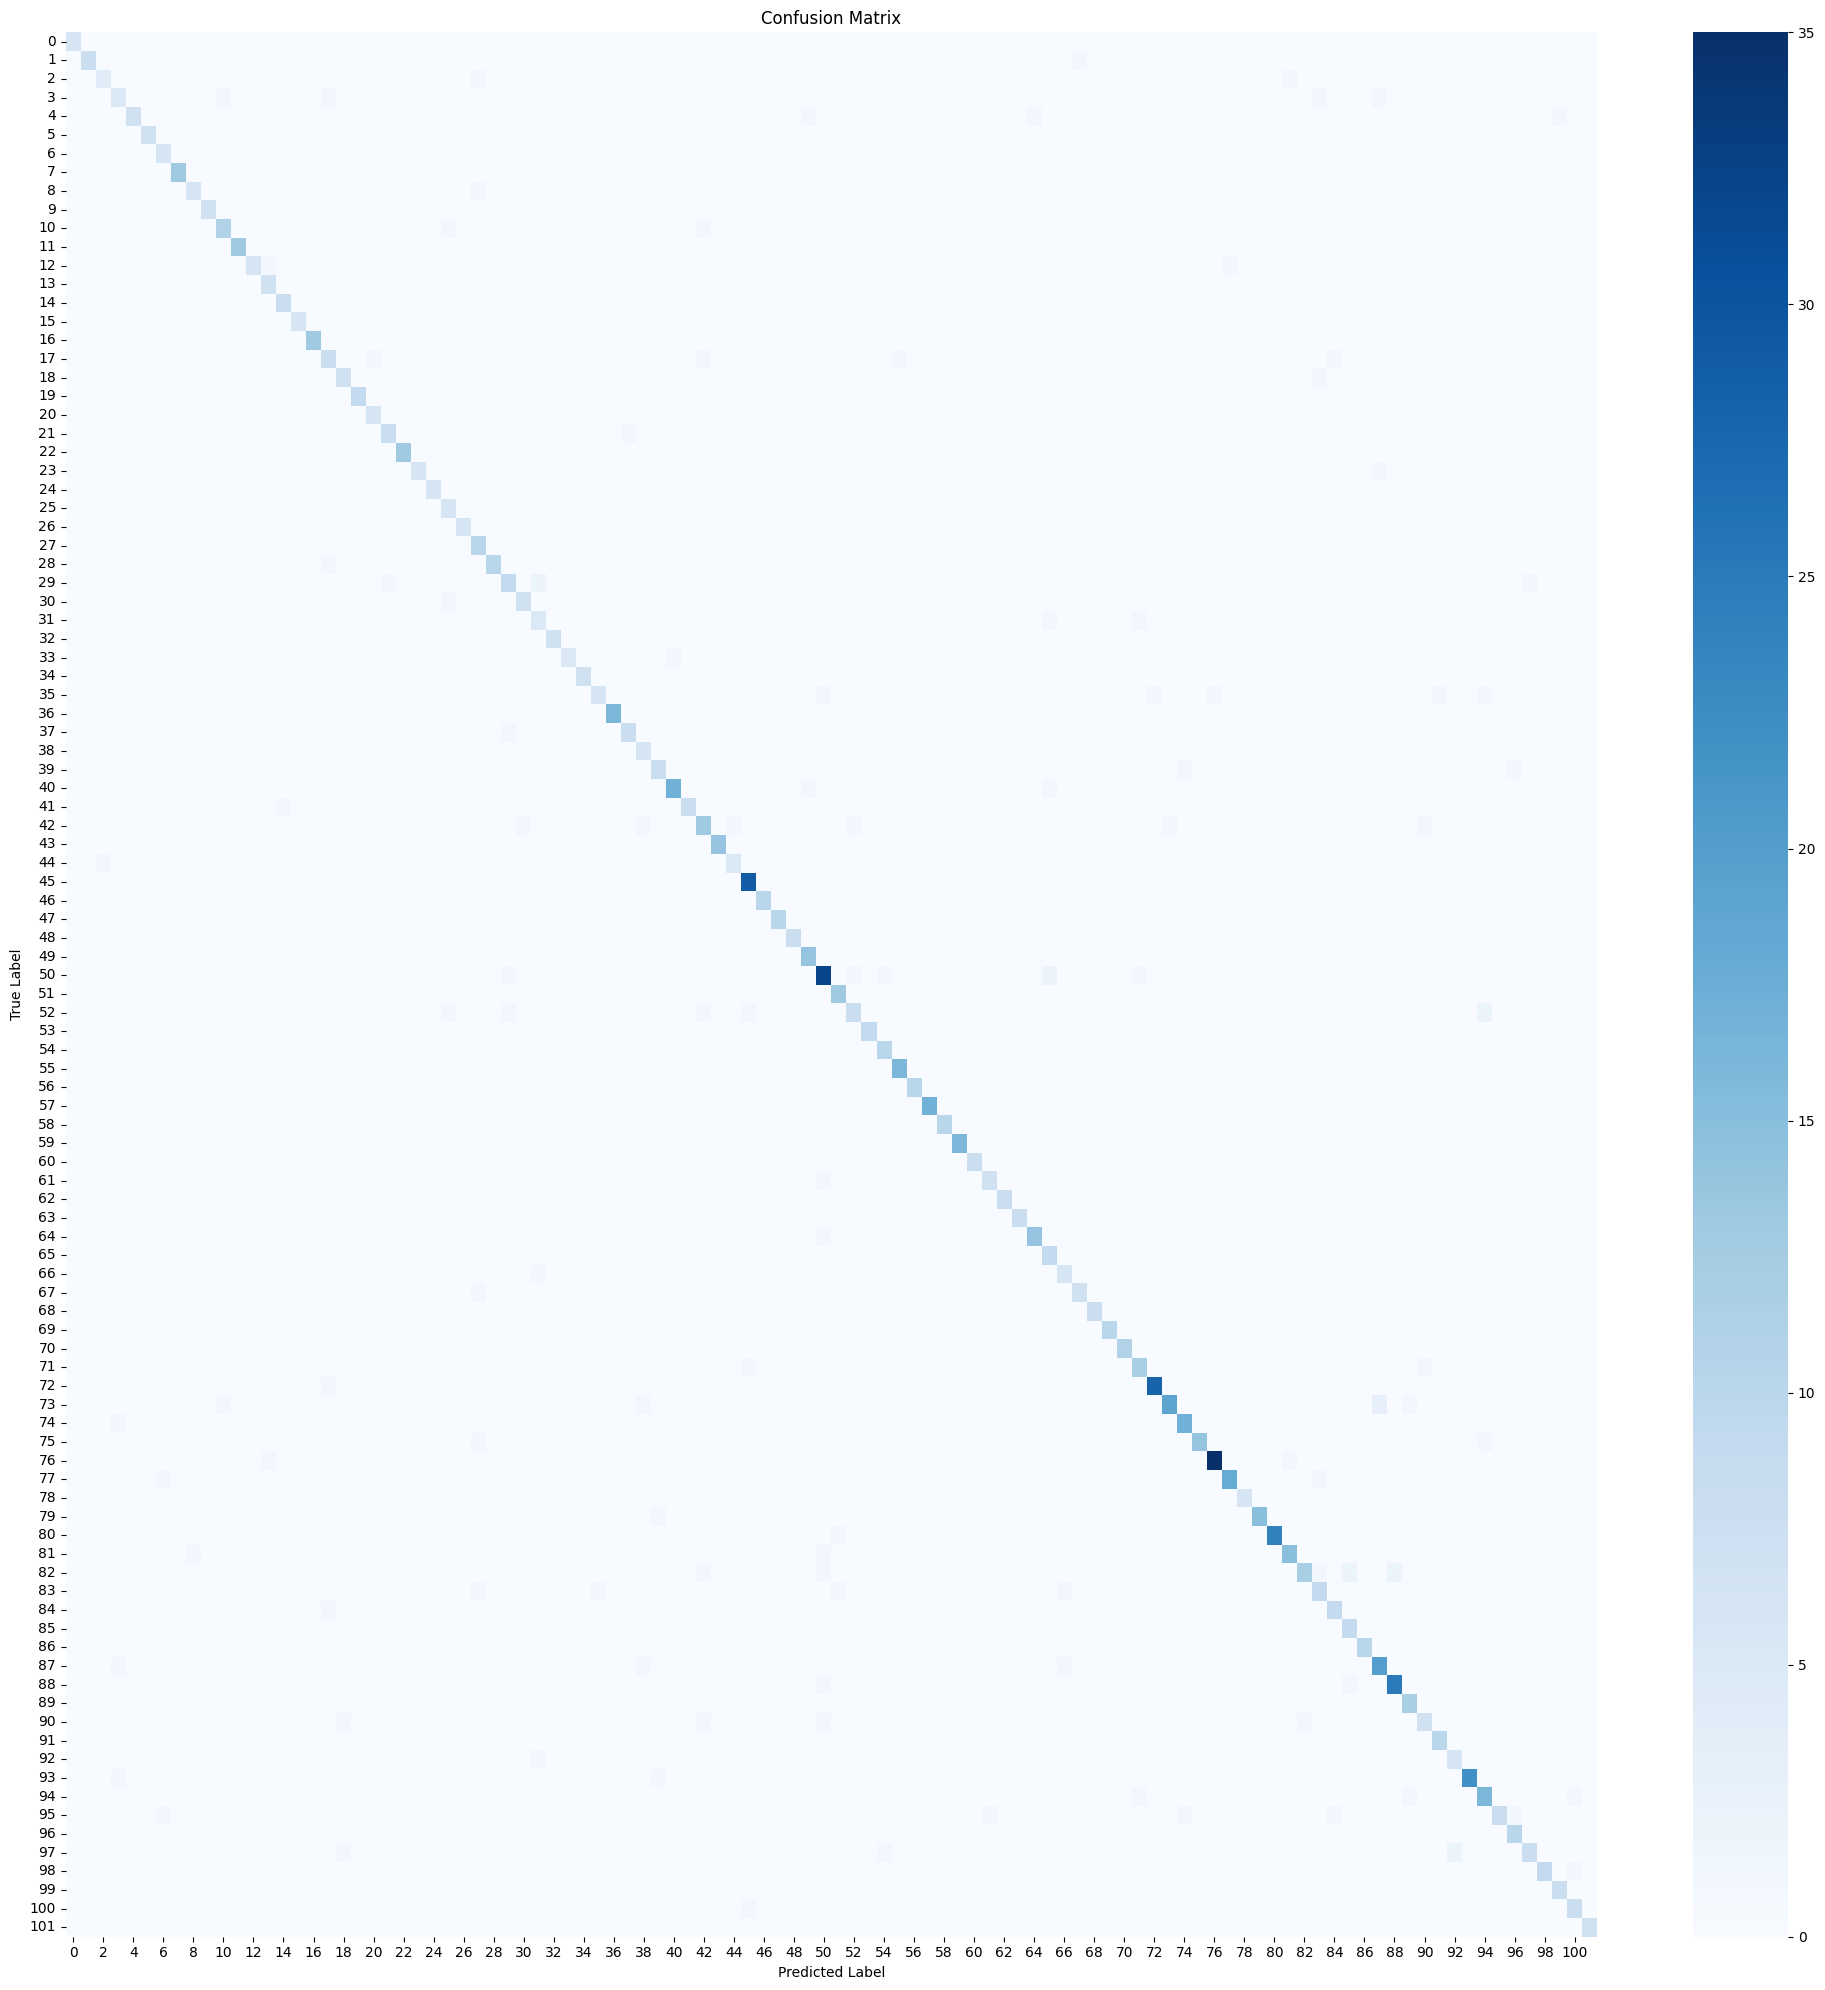

Classes present in validation set: 102/102
Mean accuracy (for present classes): 0.9062
Confusion matrix evaluation complete!


In [133]:
logger.info("Running final evaluation (Confusion Matrix)...")
evaluate_metrics(model_ft, dataloaders, device, writer, num_classes=102)

Why I choose this architecture choices

ResNet18 with ImageNet pretraining
- Computational efficiency vs deeper architectures
- Suitable feature extraction for fine-grained tasks
- Balance between capacity and overfitting risk

Transfer learning strategy
- Reduce training time and computational resources
- Prevent catastrophic forgetting
- Focus learning on task-specific classification laye

Custom stratified splitting
- Original 10/10/80 split problematic for training
- 70/15/15 provides sufficient training data
- Maintains class distribution across splits

Data augmentation strategy (data.loader from gets_transform)
- Random crops, flips, color jitter, rotation
- Appropriate for flower image variations
- Increases effective dataset size

Class weighting 
- Addresses imbalance in fine-grained datasets
- Adjusts loss function to prioritize underrepresented classes
- Prevents bias toward majority classes

Hyperparameter choices
- Learning rate (0.001) - conservative for transfer learning
- SGD with momentum (0.9) - stable optimization
- Batch size (32) - memory-efficient for ResNet18


